In [6]:
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import DataLoader, Data
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from itertools import combinations
from livelossplot import PlotLosses
from tqdm import tqdm


def extract_subgraphs_and_indicators(graph, size_m, embedding_dim=16):
    subgraph_embeddings = []
    indicators = []
    for node_set in combinations(graph.nodes(), size_m):
        subgraph = graph.subgraph(node_set)
        if len(subgraph.edges()) > 0:  # ensure there's at least one edge in the subgraph

            # Compute the WL embedding for the subgraph
            #wl_embedding = compute_WL_embedding(subgraph)
            # TODO: replace by true WL embedding
            wl_embedding = torch.rand(embedding_dim, 1)
            subgraph_embeddings.append(wl_embedding)

            # Create the indicator for nodes in the subgraph
            indicator = [1 if node in node_set else 0 for node in graph.nodes()]
            indicators.append(indicator)

    return subgraph_embeddings, indicators


n = 10
m = 5
embedding_dim = 5

# Step 1: Construct a graph and generate its subgraphs
G = nx.erdos_renyi_graph(n=n, p=0.5)

# Extract all subgraphs of size m=10
subgraph_embeddings, indicators = extract_subgraphs_and_indicators(G, m, embedding_dim)


In [7]:
# Create a dataset
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graph, indicators, subgraph_embeddings):
        super(GraphDataset, self).__init__()
        self.graph = graph
        self.indicators = indicators
        self.subgraph_embeddings = subgraph_embeddings

    def __len__(self):
        return len(self.indicators)

    def __getitem__(self, idx):
        # Convert graph to Data object for PyTorch Geometric
        edge_index = torch.tensor(list(self.graph.edges)).t().contiguous()

        # Assign the indicator as the node feature
        x = torch.tensor(self.indicators[idx], dtype=torch.float).view(-1, 1)

        # The corresponding WL embedding for the subgraph
        y = torch.tensor(self.subgraph_embeddings[idx], dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, y=y)
        return data


batch_size = 8
dataset = GraphDataset(G, indicators, subgraph_embeddings)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


/Users/amitboy/.local/share/virtualenvs/GraphMatching-LGBFh8ro/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:

class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, num_layers):
        super(GCN, self).__init__()

        self.num_layers = num_layers

        # Define the first layer
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_channels, hidden_channels))

        # Define the hidden layers
        for _ in range(
                num_layers - 2):  # -2 because we manually define the first and last layers
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Define the output layer
        self.convs.append(GCNConv(hidden_channels, output_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply the first layer
        x = self.convs[0](x, edge_index)
        x = F.relu(x)

        # Apply the hidden layers
        for i in range(1, self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)

        # Apply the output layer
        x = self.convs[self.num_layers - 1](x, edge_index)
        x = global_mean_pool(x, data.batch)  # Pool to graph level

        return x

# Example usage:
#model = GCN(input_channels=1, hidden_channels=16, output_channels=16, num_layers=3)


In [9]:

input_dim = 1
hidden_dim = 32
output_dim = embedding_dim
num_layers = 5
kernel_size = n  # for pooling
model = GCN(input_dim, hidden_dim, output_dim,
            num_layers)  # 1 input feature, 32 hidden features, 16 output features (embedding size)


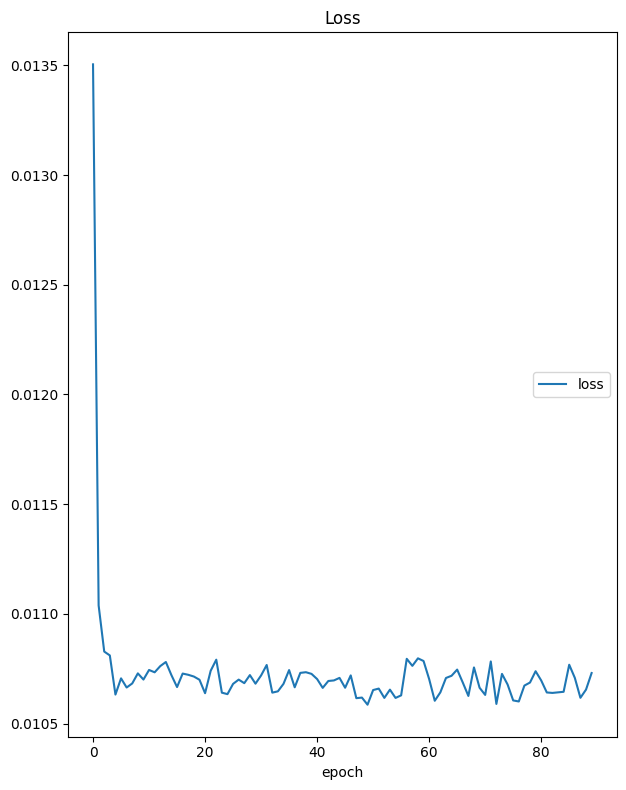

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]

Loss
	loss             	 (min:    0.011, max:    0.014, cur:    0.011)
Finished Training


In [10]:


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, epochs, train_loader, optimizer, criterion, k_plot):
    liveloss = PlotLosses()

    model.train()
    for epoch in tqdm(range(epochs)):
        logs = {}
        running_loss = 0.0

        for batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            out = model(batch)
            loss = criterion(out, batch.y.reshape(out.shape))

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(train_loader.dataset)
        logs['loss'] = average_loss

        if np.mod(epoch, k_plot):
            liveloss.update(logs)
            liveloss.send()

    print('Finished Training')


train(model, epochs=100, train_loader=loader, optimizer=optimizer, criterion=criterion,
      k_plot=10)


In [11]:
# Assuming your dataset is defined as 'dataset'
eval_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Evaluation
with torch.no_grad():
    for data in eval_loader:
        out = model(data)
        print("Predicted embedding:", out)
        print("Actual embedding:", data.y.reshape(out.shape))
        print("error:", torch.norm(data.y.reshape(out.shape) - out))


Predicted embedding: tensor([[0.4882, 0.4485, 0.4775, 0.5254, 0.5107],
        [0.4897, 0.4495, 0.4781, 0.5265, 0.5122],
        [0.4875, 0.4480, 0.4773, 0.5248, 0.5100],
        [0.4875, 0.4480, 0.4773, 0.5248, 0.5099],
        [0.4875, 0.4480, 0.4773, 0.5248, 0.5099],
        [0.4875, 0.4480, 0.4773, 0.5248, 0.5099],
        [0.4836, 0.4454, 0.4758, 0.5220, 0.5061],
        [0.4814, 0.4439, 0.4750, 0.5204, 0.5039],
        [0.4813, 0.4439, 0.4749, 0.5203, 0.5039],
        [0.4813, 0.4439, 0.4750, 0.5203, 0.5039],
        [0.4813, 0.4439, 0.4749, 0.5203, 0.5039],
        [0.4829, 0.4449, 0.4756, 0.5215, 0.5054],
        [0.4828, 0.4449, 0.4755, 0.5214, 0.5054],
        [0.4828, 0.4449, 0.4755, 0.5215, 0.5054],
        [0.4828, 0.4449, 0.4755, 0.5214, 0.5054],
        [0.4806, 0.4434, 0.4747, 0.5198, 0.5032],
        [0.4806, 0.4434, 0.4747, 0.5198, 0.5032],
        [0.4806, 0.4434, 0.4747, 0.5198, 0.5032],
        [0.4806, 0.4434, 0.4747, 0.5198, 0.5032],
        [0.4805, 0.4434, 0.47

/var/folders/jj/vflljh217_96cgt1xr_qwlp40000gn/T/ipykernel_27863/1342459059.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.subgraph_embeddings[idx], dtype=torch.float)


In [12]:

# Step 5: Visualization and Evaluation

# Extract all predicted and actual embeddings
predicted_embeddings = []
actual_embeddings = []

with torch.no_grad():
    for data in loader:
        out = model(data)
        predicted_embeddings.extend(out.tolist())
        actual_embeddings.extend(data.y.tolist())

# Convert to numpy arrays
predicted_embeddings = np.array(predicted_embeddings)
actual_embeddings = np.array(actual_embeddings)

# Compute the mean squared error between predicted and actual embeddings
mse = mean_squared_error(actual_embeddings, predicted_embeddings)
print(f"Mean Squared Error between predicted and actual embeddings: {mse:.4f}")

# Use t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
all_embeddings = np.vstack((actual_embeddings, predicted_embeddings))
embedded = tsne.fit_transform(all_embeddings)

# Split the t-SNE transformed embeddings
actual_tsne = embedded[:len(actual_embeddings)]
predicted_tsne = embedded[len(actual_embeddings):]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(actual_tsne[:, 0], actual_tsne[:, 1], c='r', label='Actual Embeddings')
plt.scatter(predicted_tsne[:, 0], predicted_tsne[:, 1], c='b', marker='x',
            label='Predicted Embeddings')
plt.legend()
plt.title("t-SNE visualization of embeddings")
plt.show()


/var/folders/jj/vflljh217_96cgt1xr_qwlp40000gn/T/ipykernel_27863/1342459059.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.subgraph_embeddings[idx], dtype=torch.float)


ValueError: Found input variables with inconsistent numbers of samples: [1260, 252]